In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

## Load the dataset

In [3]:
# Load Data
# Assuming the data is in a list of dictionaries as described
file_path = 'combined_with_dans.pickle'
data = pd.read_pickle(file_path)

In [4]:
print(len(data))

1190559


In [5]:
data.head()

,board,recommended_column
0,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3
1,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",3
2,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2
3,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",1
4,"[[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, ...",2


In [6]:
print(type(data['recommended_column'][0]))

<class 'numpy.int64'>


## Data Preprocessing

In [7]:
import numpy as np
import tensorflow as tf

def preprocess_data(data):
    boards = []
    labels = []
    
    # Iterate over board_x and play_y simultaneously
    for board, label in zip(data['board'], data['recommended_column']):
        board = np.array(board)  # Ensure board is a NumPy array

        # Add original board
        boards.append(board)
        labels.append(label)

        # Augmentation: Flip the board horizontally (flip both channels)
        flipped_board = np.flip(board, axis=1)  # Flip along the columns
        flipped_label = 6 - label  # Adjust column index (since board is 7 columns wide)

        # Add flipped board to dataset
        boards.append(flipped_board)
        labels.append(flipped_label)

    # Convert lists to NumPy arrays
    boards = np.array(boards)
    labels = np.array(labels)
    
    # One-hot encode labels (7 possible moves)
    labels = tf.keras.utils.to_categorical(labels, num_classes=7)
    
    return boards, labels

# Preprocess dataset
boards, labels = preprocess_data(data)

# Print shapes to verify
print(f"Boards shape: {boards.shape}")  # Should be (2 * num_samples, 6, 7, 2)
print(f"Labels shape: {labels.shape}")  # Should be (2 * num_samples, 7)


Boards shape: (2381118, 6, 7, 2)
Labels shape: (2381118, 7)


In [8]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(boards, labels, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}, Validation size: {X_val.shape}")

Train size: (1904894, 6, 7, 2), Validation size: (476224, 6, 7, 2)


## CNN

In [9]:
def build_cnn():
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(6, 7, 2), padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 3
        layers.Conv2D(128, (5, 5), activation='gelu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (5, 5), activation='gelu', padding="same"),
        layers.BatchNormalization(),

        # flatten & dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(7, activation='softmax')  # Output layer
    ])
    
    # Compile Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

cnn_model = build_cnn()


# Train CNN
cnn_model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 7, 64)       │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,775 (4.89 MB)

 Trainable params: 1,279,495 (4.88 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss doesn't improve
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model to the best state
)

# fit model
history = cnn_model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=128, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add EarlyStopping
)


Epoch 1/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 535s 36ms/step - accuracy: 0.4950 - loss: 1.3530 - val_accuracy: 0.6364 - val_loss: 0.9370
Epoch 2/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 575s 39ms/step - accuracy: 0.6425 - loss: 0.9339 - val_accuracy: 0.6744 - val_loss: 0.8363
Epoch 3/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 598s 40ms/step - accuracy: 0.6774 - loss: 0.8369 - val_accuracy: 0.6908 - val_loss: 0.7894
Epoch 4/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 622s 42ms/step - accuracy: 0.7004 - loss: 0.7749 - val_accuracy: 0.7053 - val_loss: 0.7515
Epoch 5/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 647s 43ms/step - accuracy: 0.7170 - loss: 0.7309 - val_accuracy: 0.7183 - val_loss: 0.7195
Epoch 6/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 643s 43ms/step - accuracy: 0.7306 - loss: 0.6965 - val_accuracy: 0.7272 - val_loss: 0.6988
Epoch 7/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 637s 43ms/step - accuracy: 0.7419 - loss: 0.6677 - val_accuracy: 0.7366 - val_loss: 0.6786
Epoch 8/20
14882/14882 ━━━━━━━━━━━━━━━━━━━━ 632s 42ms/s

In [11]:
# plot results
cnn_model.evaluate(X_val, y_val)    


14882/14882 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.7894 - loss: 0.5580


[0.5584501624107361, 0.7896913886070251]

In [28]:
# export model results
cnn_model.save('cnn_model.h5')

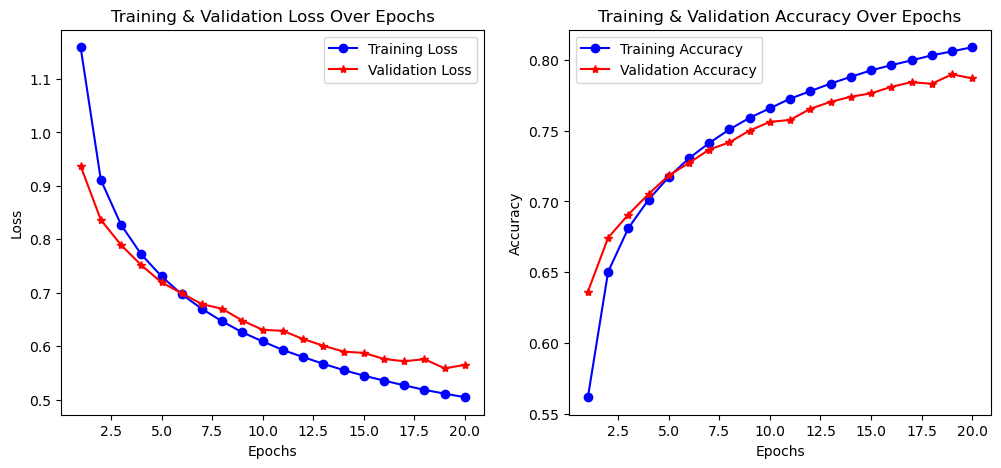

In [20]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # Blue circles
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')  # Red stars
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # Blue circles
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')  # Red stars
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()

# Show plots
plt.show()


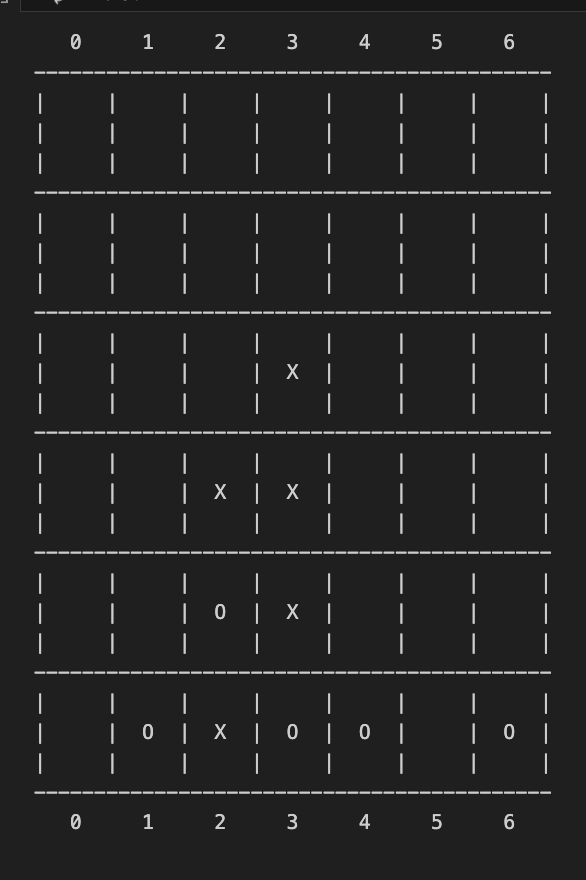
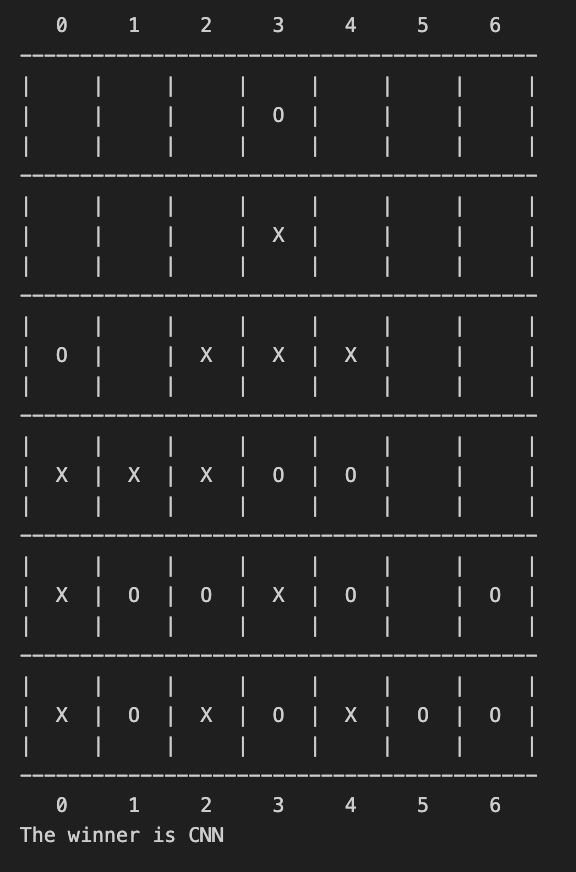
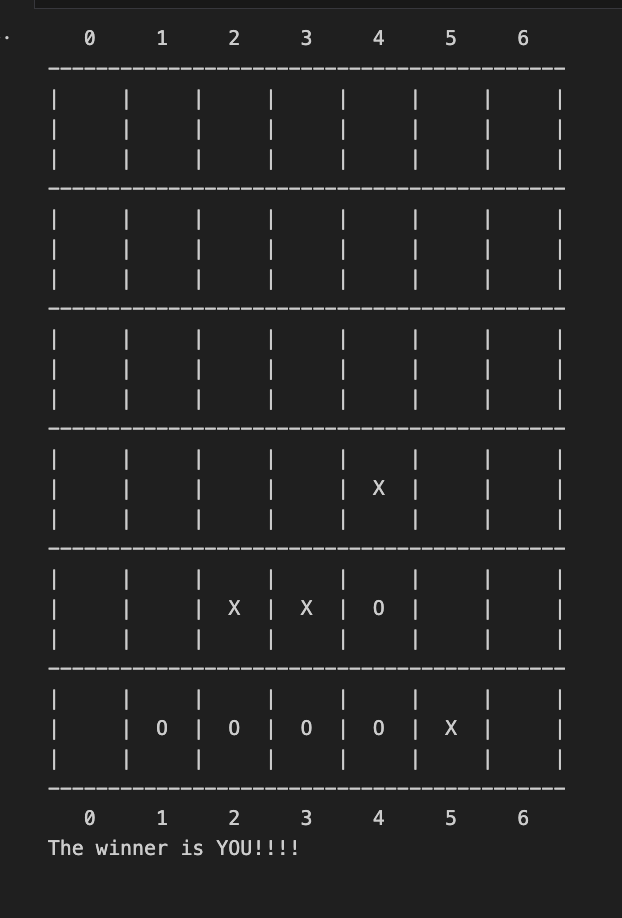